In [5]:
 ! pip install -q kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pankajsaroha","key":"54207e14db3551d800f12b8a5b84887a"}'}

In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-26 21:13:45           6101  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3415  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1206  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1950  
promptcloud/care

In [10]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 96% 313M/325M [00:04<00:00, 55.4MB/s]
100% 325M/325M [00:04<00:00, 69.1MB/s]


In [ ]:
!unzip skin-cancer-malignant-vs-benign.zip

In [12]:
!rm -rf test
!rm -rf train

In [13]:
import torch


from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import cv2
import numpy as np
from PIL import Image
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [14]:
train_dir=["/content/data/train/benign","/content/data/train/malignant"]

j=0
for img in os.listdir(train_dir[0]):
        img_array=cv2.imread(os.path.join(train_dir[0],img))
        print("image {} is of shape :".format(j+1),img_array.shape)
        j=j+1
        if(j>10):
            break

#We can see the image is of size (224,224,3) but if some images are not then while transforming we will take care of that and change all images to this size if they are not

image 1 is of shape : (224, 224, 3)
image 2 is of shape : (224, 224, 3)
image 3 is of shape : (224, 224, 3)
image 4 is of shape : (224, 224, 3)
image 5 is of shape : (224, 224, 3)
image 6 is of shape : (224, 224, 3)
image 7 is of shape : (224, 224, 3)
image 8 is of shape : (224, 224, 3)
image 9 is of shape : (224, 224, 3)
image 10 is of shape : (224, 224, 3)
image 11 is of shape : (224, 224, 3)


In [16]:
# Declaring the transformations
transformations = transforms.Compose([transforms.Resize((224,224))
                                     ,transforms.ToTensor()
                                     #,transforms.Normalize([0.7602256958847052, 0.5367317020664847, 0.5379252559302429],
                                     #                      [0.15167462228782724, 0.16006405651145883, 0.17655698694696795])
                                     ])

In [17]:
# Declaring the path to the dataset# 

path_train="/content/data/train"
path_test="/content/data/test"

train_set=ImageFolder(path_train,transform=transformations)
test_set=ImageFolder(path_test,transform=transformations)


In [18]:
#Let's check the no of images in the training and test set
print("No. of images in train set is {} and in test set is {}".format(len(train_set),len(test_set)))

No. of images in train set is 2637 and in test set is 660


In [19]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=64,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size = 660,
                                          shuffle=True)

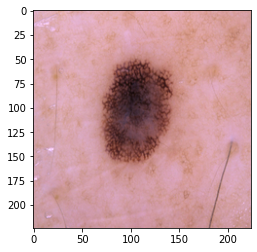

In [20]:
#Let's see our one of the image

img,label=train_set[0];
plt.imshow(img.permute(1,2,0));
img.shape;

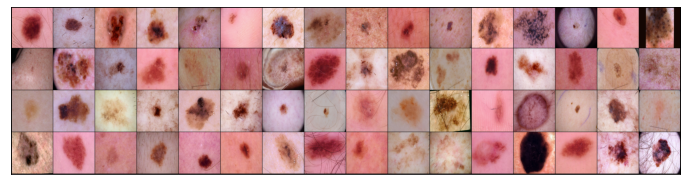

In [21]:
# or maybe let's make a grid where we can see many images at a time

from torchvision.utils import make_grid

def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=((12,6)))
        ax.set_xticks([]);
        ax.set_yticks([]);
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)
#Here we can see 64 images at a time because we have run this for one batch and batch_size is 64.

In [22]:
#Checking the mean and standard deviation of the training dataset

loader=DataLoader(train_set,batch_size=len(train_set),num_workers=1)
data=next(iter(loader))
data[0].mean(),data[0].std()

# we can use this to normalize the value

(tensor(0.6116), tensor(0.1940))

In [23]:
#https://gist.github.com/jdhao/9a86d4b9e4f79c5330d54de991461fd6
#by this function we can find the mean,std value of each channel i.e. r,g,b respectively which will help us in normalization of the channels

import numpy as np
from os import listdir
from os.path import join, isdir
from glob import glob
import cv2
import timeit

# number of channels of the dataset image, 3 for color jpg, 1 for grayscale img
# you need to change it to reflect your dataset
CHANNEL_NUM = 3


def cal_dir_stat(root):
    cls_dirs = [d for d in listdir(root) if isdir(join(root, d))]
    pixel_num = 0 # store all pixel number in the dataset
    channel_sum = np.zeros(CHANNEL_NUM)
    channel_sum_squared = np.zeros(CHANNEL_NUM)

    for idx, d in enumerate(cls_dirs):
        #print("#{} class".format(idx))
        im_pths = glob(join(root, d, "*.jpg"))

        for path in im_pths:
            im = cv2.imread(path) # image in M*N*CHANNEL_NUM shape, channel in BGR order
            im = im/255.0
            pixel_num += (im.size/CHANNEL_NUM)
            channel_sum += np.sum(im, axis=(0, 1))
            channel_sum_squared += np.sum(np.square(im), axis=(0, 1))

    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))
    
    # change the format from bgr to rgb
    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]
    
    return rgb_mean, rgb_std

# The script assumes that under train_root, there are separate directories for each class
# of training images.
train_root = path_train
start = timeit.default_timer()
mean, std = cal_dir_stat(train_root)
end = timeit.default_timer()
#print("elapsed time: {}".format(end-start))
print("mean:{}\nstd:{}".format(mean, std))


mean:[0.7602256958847073, 0.5367317020664844, 0.5379252559302418]
std:[0.15167462228782394, 0.16006405651146038, 0.17655698694697392]


In [24]:
model= nn.Sequential(nn.Conv2d(3,5,kernel_size=3,stride=1,padding=1)
                             ,nn.MaxPool2d(2,2)
                             ,nn.Conv2d(5,8,kernel_size=3,stride=1,padding=1)
                             ,nn.MaxPool2d(2,2)
                             ,nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1)
                             ,nn.MaxPool2d(2,2)
                             ,nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
                             ,nn.MaxPool2d(2,2)
                             ,nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
                             ,nn.MaxPool2d(2,2)
                             ,nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
                             ,nn.MaxPool2d(2,2)
                             ,nn.Flatten()
                             ,nn.Linear(1152,256)
                             ,nn.Dropout(0.25)
                             ,nn.ReLU()
                             ,nn.Linear(256,64)
                             ,nn.Dropout(0.25)
                             ,nn.ReLU()
                             ,nn.Linear(64,2)
                             )
model.eval()

Sequential(
  (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_f

In [25]:
for images,label in train_loader:
    print(images.shape,label.shape)
    
    out=model(images)
    print(out.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 2])


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
from torch import optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [28]:
model=model.to(device)
train_loss_array=[]
for e in range(0,20):
    train_loss=0
    accuracy=0
    start = time.time()
    for images,labels in train_loader:
        #images=images.permute(1,2,0)
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        output=model(images)
        loss=criterion(output,labels.reshape(-1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        #Taking the maximum value of the classes output 
        _, top_class = output.topk(1, dim=1)
        # Check how many of the classes are correct
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    accuracy=accuracy/len(train_loader)*100
    end=time.time()-start
    train_loss=train_loss/len(train_loader.dataset)
    train_loss_array.append(train_loss)
    print("epoch {}, training loss {},accuracy {}, time {} ".format(e+1,train_loss,accuracy,end))
    

epoch 1, training loss 0.6479224598131986,accuracy 61.1349588348752, time 7.692018032073975 
epoch 2, training loss 0.5243711253662746,accuracy 74.52495424520403, time 7.480454921722412 
epoch 3, training loss 0.48124445323289505,accuracy 77.10050372850328, time 7.477648735046387 
epoch 4, training loss 0.4347711009964782,accuracy 78.36824634245464, time 7.42303204536438 
epoch 5, training loss 0.4466696456837573,accuracy 77.65281597773233, time 7.443779468536377 
epoch 6, training loss 0.4118014099609685,accuracy 80.40006870315189, time 7.468266010284424 
epoch 7, training loss 0.37034383916836777,accuracy 81.74221614996591, time 7.457627058029175 
epoch 8, training loss 0.36886336173258993,accuracy 82.37751835868472, time 7.4528586864471436 
epoch 9, training loss 0.37376538953141003,accuracy 81.81089744681404, time 7.433265924453735 
epoch 10, training loss 0.3556660066895924,accuracy 82.78102108410427, time 7.3856871128082275 
epoch 11, training loss 0.33388343124530695,accuracy 83

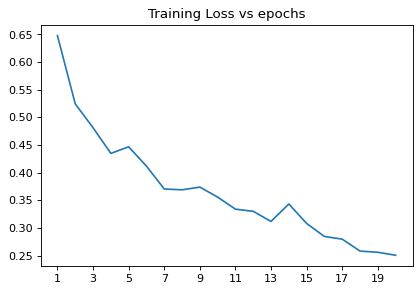

In [29]:
x=np.arange(1,21);
from matplotlib.pyplot import figure

figure(figsize=(6, 4), dpi=80);
plt.plot(x,train_loss_array);
plt.title("Training Loss vs epochs");
plt.xticks(range(1,21,2));


In [30]:
test_accuracy=0
start = time.time()
for images_test,labels_test in test_loader:
        
        images_test, labels_test = images_test.to(device), labels_test.to(device)        
        output_test=model(images_test)
         
        _, top_class_test = output_test.topk(1, dim=1)
        # Check how many of the classes are correct
        equals_test = top_class_test == labels_test.view(*top_class_test.shape)
        test_accuracy += torch.mean(equals_test.type(torch.FloatTensor)).item()

test_accuracy=test_accuracy/len(test_loader)*100
end=time.time()-start
print("test accuracy {}, time {} ".format(test_accuracy,end))

#x_test,y_test = next(iter(test_loader))
#x_test=x_test.to(device)
#y_test=y_test.to(device)
#y_pred = (model(x_test).argmax(dim=1))
#print("Accuracy is : ",(y_pred.eq(y_test).sum()/660.).item()*100,"%")

test accuracy 83.63636136054993, time 2.0537734031677246 
